  1%|          | 7/1000 [00:00<00:15, 65.62it/s]

y[0]とo[0] [ 0.44692584] [ 1.]
y[1]とo[1] [ 0.55307416] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44695083] [ 1.]
y[1]とo[1] [ 0.55304917] [ 0.]
y[0]とo[0] [ 0.44680981] [ 1.]
y[1]とo[1] [ 0.55319019] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44683458] [ 1.]
y[1]とo[1] [ 0.55316542] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44685941] [ 1.]
y[1]とo[1] [ 0.55314059] [ 0.]
y[0]とo[0] [ 0.44671816] [ 1.]
y[1]とo[1] [ 0.55328184] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44674276] [ 1.]
y[1]とo[1] [ 0.55325724] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44676742] [ 1.]
y[1]とo[1] [ 0.55323258] [ 0.]
y[0]とo[0] [ 0.44662597] [ 1.]
y[1]とo[1] [ 0.55337403] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44665039] [ 1.]
y[1]とo[1] [ 0.55334961] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] 

  2%|▏         | 16/1000 [00:00<00:20, 48.44it/s]


y[0]とo[0] [ 0.44596575] [ 1.]
y[1]とo[1] [ 0.55403425] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44598877] [ 1.]
y[1]とo[1] [ 0.55401123] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44601182] [ 1.]
y[1]とo[1] [ 0.55398818] [ 0.]
y[0]とo[0] [ 0.44586937] [ 1.]
y[1]とo[1] [ 0.55413063] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44589217] [ 1.]
y[1]とo[1] [ 0.55410783] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44591499] [ 1.]
y[1]とo[1] [ 0.55408501] [ 0.]
y[0]とo[0] [ 0.44577251] [ 1.]
y[1]とo[1] [ 0.55422749] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44579507] [ 1.]
y[1]とo[1] [ 0.55420493] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44581765] [ 1.]
y[1]とo[1] [ 0.55418235] [ 0.]
y[0]とo[0] [ 0.44567516] [ 1.]
y[1]とo[1] [ 0.55432484] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1]

  3%|▎         | 29/1000 [00:00<00:18, 53.57it/s]

 [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44522332] [ 1.]
y[1]とo[1] [ 0.55477668] [ 0.]
y[0]とo[0] [ 0.4450813] [ 1.]
y[1]とo[1] [ 0.5549187] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44510197] [ 1.]
y[1]とo[1] [ 0.55489803] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44512264] [ 1.]
y[1]とo[1] [ 0.55487736] [ 0.]
y[0]とo[0] [ 0.4449808] [ 1.]
y[1]とo[1] [ 0.5550192] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44500116] [ 1.]
y[1]とo[1] [ 0.55499884] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44502152] [ 1.]
y[1]とo[1] [ 0.55497848] [ 0.]
y[0]とo[0] [ 0.44487988] [ 1.]
y[1]とo[1] [ 0.55512012] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44489994] [ 1.]
y[1]とo[1] [ 0.55510006] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44491997] [ 1.]
y[1]とo[1] [ 0.55508003] [ 0.]
y[0]とo[

  4%|▍         | 39/1000 [00:00<00:19, 48.56it/s]

 [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44377932] [ 1.]
y[1]とo[1] [ 0.55622068] [ 0.]
y[0]とo[0] [ 0.44364275] [ 1.]
y[1]とo[1] [ 0.55635725] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44365839] [ 1.]
y[1]とo[1] [ 0.55634161] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44367397] [ 1.]
y[1]とo[1] [ 0.55632603] [ 0.]
y[0]とo[0] [ 0.44353806] [ 1.]
y[1]とo[1] [ 0.55646194] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44355329] [ 1.]
y[1]とo[1] [ 0.55644671] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44356844] [ 1.]
y[1]とo[1] [ 0.55643156] [ 0.]
y[0]とo[0] [ 0.44343325] [ 1.]
y[1]とo[1] [ 0.55656675] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44344805] [ 1.]
y[1]とo[1] [ 0.55655195] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44346277] [ 1.]
y[1

  5%|▍         | 49/1000 [00:01<00:20, 45.36it/s]


y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44271025] [ 1.]
y[1]とo[1] [ 0.55728975] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44272181] [ 1.]
y[1]とo[1] [ 0.55727819] [ 0.]
y[0]とo[0] [ 0.44259395] [ 1.]
y[1]とo[1] [ 0.55740605] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44260515] [ 1.]
y[1]とo[1] [ 0.55739485] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44261624] [ 1.]
y[1]とo[1] [ 0.55738376] [ 0.]
y[0]とo[0] [ 0.44248953] [ 1.]
y[1]とo[1] [ 0.55751047] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44250025] [ 1.]
y[1]とo[1] [ 0.55749975] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44251087] [ 1.]
y[1]とo[1] [ 0.55748913] [ 0.]
y[0]とo[0] [ 0.44238535] [ 1.]
y[1]とo[1] [ 0.55761465] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4423956] [ 1.]
y[1]とo[1] 

  6%|▌         | 60/1000 [00:01<00:20, 45.22it/s]

[ 0.44166784] [ 1.]
y[1]とo[1] [ 0.55833216] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44167481] [ 1.]
y[1]とo[1] [ 0.55832519] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44168167] [ 1.]
y[1]とo[1] [ 0.55831833] [ 0.]
y[0]とo[0] [ 0.44156775] [ 1.]
y[1]とo[1] [ 0.55843225] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44157426] [ 1.]
y[1]とo[1] [ 0.55842574] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44158066] [ 1.]
y[1]とo[1] [ 0.55841934] [ 0.]
y[0]とo[0] [ 0.44146846] [ 1.]
y[1]とo[1] [ 0.55853154] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44147452] [ 1.]
y[1]とo[1] [ 0.55852548] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44148047] [ 1.]
y[1]とo[1] [ 0.55851953] [ 0.]
y[0]とo[0] [ 0.44137005] [ 1.]
y[1]とo[1] [ 0.55862995] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.551799

  7%|▋         | 72/1000 [00:01<00:18, 51.17it/s]


y[1]とo[1] [ 0.55928189] [ 0.]
y[0]とo[0] [ 0.44062431] [ 1.]
y[1]とo[1] [ 0.55937569] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44062673] [ 1.]
y[1]とo[1] [ 0.55937327] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44062905] [ 1.]
y[1]とo[1] [ 0.55937095] [ 0.]
y[0]とo[0] [ 0.44053763] [ 1.]
y[1]とo[1] [ 0.55946237] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44053971] [ 1.]
y[1]とo[1] [ 0.55946029] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44054171] [ 1.]
y[1]とo[1] [ 0.55945829] [ 0.]
y[0]とo[0] [ 0.44045273] [ 1.]
y[1]とo[1] [ 0.55954727] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44045449] [ 1.]
y[1]とo[1] [ 0.55954551] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44045617] [ 1.]
y[1]とo[1] [ 0.55954383] [ 0.]
y[0]とo[0] [ 0.44036971] [ 1.]
y[1]とo[1] [ 0.55963029] [ 0.]
y[0]とo[0]

  8%|▊         | 84/1000 [00:01<00:17, 51.00it/s]


y[0]とo[0] [ 0.43972466] [ 1.]
y[1]とo[1] [ 0.56027534] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43972438] [ 1.]
y[1]とo[1] [ 0.56027562] [ 0.]
y[0]とo[0] [ 0.43966671] [ 1.]
y[1]とo[1] [ 0.56033329] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43966638] [ 1.]
y[1]とo[1] [ 0.56033362] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43966604] [ 1.]
y[1]とo[1] [ 0.56033396] [ 0.]
y[0]とo[0] [ 0.43961159] [ 1.]
y[1]とo[1] [ 0.56038841] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43961122] [ 1.]
y[1]とo[1] [ 0.56038878] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43961086] [ 1.]
y[1]とo[1] [ 0.56038914] [ 0.]
y[0]とo[0] [ 0.43955969] [ 1.]
y[1]とo[1] [ 0.56044031] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43955931] [ 1.]
y[1]とo[1] [ 0.56044069] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1]

 10%|▉         | 97/1000 [00:01<00:17, 51.76it/s]

[ 0.56072651] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43927414] [ 1.]
y[1]とo[1] [ 0.56072586] [ 0.]
y[0]とo[0] [ 0.43925461] [ 1.]
y[1]とo[1] [ 0.56074539] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43925543] [ 1.]
y[1]とo[1] [ 0.56074457] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43925635] [ 1.]
y[1]とo[1] [ 0.56074365] [ 0.]
y[0]とo[0] [ 0.43924051] [ 1.]
y[1]とo[1] [ 0.56075949] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43924161] [ 1.]
y[1]とo[1] [ 0.56075839] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4392428] [ 1.]
y[1]とo[1] [ 0.5607572] [ 0.]
y[0]とo[0] [ 0.43923068] [ 1.]
y[1]とo[1] [ 0.56076932] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43923208] [ 1.]
y[1]とo[1] [ 0.56076792] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43923357

 11%|█         | 110/1000 [00:02<00:16, 54.25it/s]

 [ 0.43941989] [ 1.]
y[1]とo[1] [ 0.56058011] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43942593] [ 1.]
y[1]とo[1] [ 0.56057407] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43943213] [ 1.]
y[1]とo[1] [ 0.56056787] [ 0.]
y[0]とo[0] [ 0.43946484] [ 1.]
y[1]とo[1] [ 0.56053516] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43947138] [ 1.]
y[1]とo[1] [ 0.56052862] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43947809] [ 1.]
y[1]とo[1] [ 0.56052191] [ 0.]
y[0]とo[0] [ 0.43951441] [ 1.]
y[1]とo[1] [ 0.56048559] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43952146] [ 1.]
y[1]とo[1] [ 0.56047854] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.43952869] [ 1.]
y[1]とo[1] [ 0.56047131] [ 0.]
y[0]とo[0] [ 0.43956857] [ 1.]
y[1]とo[1] [ 0.56043143] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179

 12%|█▏        | 122/1000 [00:02<00:17, 51.10it/s]

y[0]とo[0] [ 0.4403497] [ 1.]
y[1]とo[1] [ 0.5596503] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44036224] [ 1.]
y[1]とo[1] [ 0.55963776] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44037494] [ 1.]
y[1]とo[1] [ 0.55962506] [ 0.]
y[0]とo[0] [ 0.44044991] [ 1.]
y[1]とo[1] [ 0.55955009] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44046289] [ 1.]
y[1]とo[1] [ 0.55953711] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44047602] [ 1.]
y[1]とo[1] [ 0.55952398] [ 0.]
y[0]とo[0] [ 0.44055371] [ 1.]
y[1]とo[1] [ 0.55944629] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44056711] [ 1.]
y[1]とo[1] [ 0.55943289] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44058066] [ 1.]
y[1]とo[1] [ 0.55941934] [ 0.]
y[0]とo[0] [ 0.44066097] [ 1.]
y[1]とo[1] [ 0.55933903] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 

 14%|█▎        | 135/1000 [00:02<00:15, 55.03it/s]

 [ 0.4416433] [ 1.]
y[1]とo[1] [ 0.5583567] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44165962] [ 1.]
y[1]とo[1] [ 0.55834038] [ 0.]
y[0]とo[0] [ 0.44175917] [ 1.]
y[1]とo[1] [ 0.55824083] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44177559] [ 1.]
y[1]とo[1] [ 0.55822441] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4417921] [ 1.]
y[1]とo[1] [ 0.5582079] [ 0.]
y[0]とo[0] [ 0.44189328] [ 1.]
y[1]とo[1] [ 0.55810672] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44190987] [ 1.]
y[1]とo[1] [ 0.55809013] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44192654] [ 1.]
y[1]とo[1] [ 0.55807346] [ 0.]
y[0]とo[0] [ 0.44202926] [ 1.]
y[1]とo[1] [ 0.55797074] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.442046] [ 1.]
y[1]とo[1] [ 0.557954] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1

 15%|█▍        | 147/1000 [00:02<00:18, 46.17it/s]

[ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44362493] [ 1.]
y[1]とo[1] [ 0.55637507] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44364174] [ 1.]
y[1]とo[1] [ 0.55635826] [ 0.]
y[0]とo[0] [ 0.44375581] [ 1.]
y[1]とo[1] [ 0.55624419] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44377249] [ 1.]
y[1]とo[1] [ 0.55622751] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44378918] [ 1.]
y[1]とo[1] [ 0.55621082] [ 0.]
y[0]とo[0] [ 0.44390368] [ 1.]
y[1]とo[1] [ 0.55609632] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44392023] [ 1.]
y[1]とo[1] [ 0.55607977] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44393678] [ 1.]
y[1]とo[1] [ 0.55606322] [ 0.]
y[0]とo[0] [ 0.44405163] [ 1.]
y[1]とo[1] [ 0.55594837] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44406803] [ 1.]
y[1]とo[1] [ 0.555931

 16%|█▌        | 158/1000 [00:03<00:17, 47.38it/s]

[ 0.55490267] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44511231] [ 1.]
y[1]とo[1] [ 0.55488769] [ 0.]
y[0]とo[0] [ 0.44522798] [ 1.]
y[1]とo[1] [ 0.55477202] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44524273] [ 1.]
y[1]とo[1] [ 0.55475727] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44525746] [ 1.]
y[1]とo[1] [ 0.55474254] [ 0.]
y[0]とo[0] [ 0.44537303] [ 1.]
y[1]とo[1] [ 0.55462697] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44538753] [ 1.]
y[1]とo[1] [ 0.55461247] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44540201] [ 1.]
y[1]とo[1] [ 0.55459799] [ 0.]
y[0]とo[0] [ 0.44551744] [ 1.]
y[1]とo[1] [ 0.55448256] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44553169] [ 1.]
y[1]とo[1] [ 0.55446831] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.445545

 17%|█▋        | 171/1000 [00:03<00:15, 52.32it/s]

 [ 1.]
y[1]とo[1] [ 0.55346807] [ 0.]
y[0]とo[0] [ 0.44664528] [ 1.]
y[1]とo[1] [ 0.55335472] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44665736] [ 1.]
y[1]とo[1] [ 0.55334264] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44666942] [ 1.]
y[1]とo[1] [ 0.55333058] [ 0.]
y[0]とo[0] [ 0.44678243] [ 1.]
y[1]とo[1] [ 0.55321757] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44679424] [ 1.]
y[1]とo[1] [ 0.55320576] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44680603] [ 1.]
y[1]とo[1] [ 0.55319397] [ 0.]
y[0]とo[0] [ 0.44691869] [ 1.]
y[1]とo[1] [ 0.55308131] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44693022] [ 1.]
y[1]とo[1] [ 0.55306978] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44694173] [ 1.]
y[1]とo[1] [ 0.55305827] [ 0.]
y[0]とo[0] [ 0.44705403] [ 1.]
y[1]とo[1] [ 0.55294597] [ 0.]
y[0

 18%|█▊        | 184/1000 [00:03<00:14, 54.91it/s]

 [ 1.]
y[1]とo[1] [ 0.55164177] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4483669] [ 1.]
y[1]とo[1] [ 0.5516331] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44837556] [ 1.]
y[1]とo[1] [ 0.55162444] [ 0.]
y[0]とo[0] [ 0.44848396] [ 1.]
y[1]とo[1] [ 0.55151604] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4484924] [ 1.]
y[1]とo[1] [ 0.5515076] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44850082] [ 1.]
y[1]とo[1] [ 0.55149918] [ 0.]
y[0]とo[0] [ 0.44860892] [ 1.]
y[1]とo[1] [ 0.55139108] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44861712] [ 1.]
y[1]とo[1] [ 0.55138288] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44862531] [ 1.]
y[1]とo[1] [ 0.55137469] [ 0.]
y[0]とo[0] [ 0.44873311] [ 1.]
y[1]とo[1] [ 0.55126689] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[

 20%|█▉        | 199/1000 [00:03<00:15, 52.79it/s]

[ 0.44983361] [ 1.]
y[1]とo[1] [ 0.55016639] [ 0.]
y[0]とo[0] [ 0.44993946] [ 1.]
y[1]とo[1] [ 0.55006054] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44994545] [ 1.]
y[1]とo[1] [ 0.55005455] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.44995144] [ 1.]
y[1]とo[1] [ 0.55004856] [ 0.]
y[0]とo[0] [ 0.45005721] [ 1.]
y[1]とo[1] [ 0.54994279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45006304] [ 1.]
y[1]とo[1] [ 0.54993696] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45006885] [ 1.]
y[1]とo[1] [ 0.54993115] [ 0.]
y[0]とo[0] [ 0.45017458] [ 1.]
y[1]とo[1] [ 0.54982542] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45018024] [ 1.]
y[1]とo[1] [ 0.54981976] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45018589] [ 1.]
y[1]とo[1] [ 0.54981411] [ 0.]
y[0]とo[0] [ 0.4502916] [ 1.]
y[1]とo[1] [ 0.5497084

 21%|██        | 212/1000 [00:04<00:14, 53.33it/s]

 [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45169034] [ 1.]
y[1]とo[1] [ 0.54830966] [ 0.]
y[0]とo[0] [ 0.45179851] [ 1.]
y[1]とo[1] [ 0.54820149] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45180232] [ 1.]
y[1]とo[1] [ 0.54819768] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45180615] [ 1.]
y[1]とo[1] [ 0.54819385] [ 0.]
y[0]とo[0] [ 0.45191474] [ 1.]
y[1]とo[1] [ 0.54808526] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45191845] [ 1.]
y[1]とo[1] [ 0.54808155] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45192218] [ 1.]
y[1]とo[1] [ 0.54807782] [ 0.]
y[0]とo[0] [ 0.45203123] [ 1.]
y[1]とo[1] [ 0.54796877] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45203484] [ 1.]
y[1]とo[1] [ 0.54796516] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45203847] [ 1.]
y[1]とo[1] [ 0.54796153] [ 0.]
y[0

 22%|██▏       | 224/1000 [00:04<00:14, 55.21it/s]

y[0]とo[0] [ 0.45359409] [ 1.]
y[1]とo[1] [ 0.54640591] [ 0.]
y[0]とo[0] [ 0.45371382] [ 1.]
y[1]とo[1] [ 0.54628618] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45371624] [ 1.]
y[1]とo[1] [ 0.54628376] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45371869] [ 1.]
y[1]とo[1] [ 0.54628131] [ 0.]
y[0]とo[0] [ 0.45383952] [ 1.]
y[1]とo[1] [ 0.54616048] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45384186] [ 1.]
y[1]とo[1] [ 0.54615814] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45384423] [ 1.]
y[1]とo[1] [ 0.54615577] [ 0.]
y[0]とo[0] [ 0.4539662] [ 1.]
y[1]とo[1] [ 0.5460338] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45396846] [ 1.]
y[1]とo[1] [ 0.54603154] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45397075] [ 1.]
y[1]とo[1] [ 0.54602925] [ 0.]
y[0]とo[0] [ 0.4540939] [ 1.]
y[1]とo[1] [ 0

 24%|██▎       | 237/1000 [00:04<00:13, 57.11it/s]

[ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4548859] [ 1.]
y[1]とo[1] [ 0.5451141] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45488754] [ 1.]
y[1]とo[1] [ 0.54511246] [ 0.]
y[0]とo[0] [ 0.45502045] [ 1.]
y[1]とo[1] [ 0.54497955] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45502196] [ 1.]
y[1]とo[1] [ 0.54497804] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4550235] [ 1.]
y[1]とo[1] [ 0.5449765] [ 0.]
y[0]とo[0] [ 0.45515802] [ 1.]
y[1]とo[1] [ 0.54484198] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45515941] [ 1.]
y[1]とo[1] [ 0.54484059] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45516084] [ 1.]
y[1]とo[1] [ 0.54483916] [ 0.]
y[0]とo[0] [ 0.45529701] [ 1.]
y[1]とo[1] [ 0.54470299] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45529829] [ 1.]
y[1]とo[1] [ 0.54470171] 

 25%|██▌       | 252/1000 [00:04<00:12, 59.42it/s]

[ 1.]
y[1]とo[1] [ 0.54274876] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45724997] [ 1.]
y[1]とo[1] [ 0.54275003] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45724872] [ 1.]
y[1]とo[1] [ 0.54275128] [ 0.]
y[0]とo[0] [ 0.45741395] [ 1.]
y[1]とo[1] [ 0.54258605] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45741236] [ 1.]
y[1]とo[1] [ 0.54258764] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4574108] [ 1.]
y[1]とo[1] [ 0.5425892] [ 0.]
y[0]とo[0] [ 0.45757852] [ 1.]
y[1]とo[1] [ 0.54242148] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45757659] [ 1.]
y[1]とo[1] [ 0.54242341] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45757469] [ 1.]
y[1]とo[1] [ 0.54242531] [ 0.]
y[0]とo[0] [ 0.45774496] [ 1.]
y[1]とo[1] [ 0.54225504] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo

 27%|██▋       | 266/1000 [00:05<00:12, 59.69it/s]

 [ 1.]
y[0]とo[0] [ 0.4595011] [ 1.]
y[1]とo[1] [ 0.5404989] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45949328] [ 1.]
y[1]とo[1] [ 0.54050672] [ 0.]
y[0]とo[0] [ 0.45969449] [ 1.]
y[1]とo[1] [ 0.54030551] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45968586] [ 1.]
y[1]とo[1] [ 0.54031414] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45967724] [ 1.]
y[1]とo[1] [ 0.54032276] [ 0.]
y[0]とo[0] [ 0.45988147] [ 1.]
y[1]とo[1] [ 0.54011853] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.45987199] [ 1.]
y[1]とo[1] [ 0.54012801] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4598625] [ 1.]
y[1]とo[1] [ 0.5401375] [ 0.]
y[0]とo[0] [ 0.46006977] [ 1.]
y[1]とo[1] [ 0.53993023] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46005938] [ 1.]
y[1]とo[1] [ 0.53994062] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[

 28%|██▊       | 280/1000 [00:05<00:11, 62.25it/s]


y[0]とo[0] [ 0.46197458] [ 1.]
y[1]とo[1] [ 0.53802542] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46195117] [ 1.]
y[1]とo[1] [ 0.53804883] [ 0.]
y[0]とo[0] [ 0.46219177] [ 1.]
y[1]とo[1] [ 0.53780823] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46216662] [ 1.]
y[1]とo[1] [ 0.53783338] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46214147] [ 1.]
y[1]とo[1] [ 0.53785853] [ 0.]
y[0]とo[0] [ 0.46238495] [ 1.]
y[1]とo[1] [ 0.53761505] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46235797] [ 1.]
y[1]とo[1] [ 0.53764203] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46233098] [ 1.]
y[1]とo[1] [ 0.53766902] [ 0.]
y[0]とo[0] [ 0.46257731] [ 1.]
y[1]とo[1] [ 0.53742269] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4625484] [ 1.]
y[1]とo[1] [ 0.5374516] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [

 30%|██▉       | 298/1000 [00:05<00:09, 73.28it/s]

[ 0.53581921] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4641306] [ 1.]
y[1]とo[1] [ 0.5358694] [ 0.]
y[0]とo[0] [ 0.46440166] [ 1.]
y[1]とo[1] [ 0.53559834] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46434856] [ 1.]
y[1]とo[1] [ 0.53565144] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46429559] [ 1.]
y[1]とo[1] [ 0.53570441] [ 0.]
y[0]とo[0] [ 0.46456869] [ 1.]
y[1]とo[1] [ 0.53543131] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46451271] [ 1.]
y[1]とo[1] [ 0.53548729] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4644569] [ 1.]
y[1]とo[1] [ 0.5355431] [ 0.]
y[0]とo[0] [ 0.46473194] [ 1.]
y[1]とo[1] [ 0.53526806] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46467302] [ 1.]
y[1]とo[1] [ 0.53532698] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4646143] [

 31%|███▏      | 314/1000 [00:05<00:10, 63.96it/s]

 [ 1.]
y[0]とo[0] [ 0.46658486] [ 1.]
y[1]とo[1] [ 0.53341514] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46647586] [ 1.]
y[1]とo[1] [ 0.53352414] [ 0.]
y[0]とo[0] [ 0.46677253] [ 1.]
y[1]とo[1] [ 0.53322747] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46665942] [ 1.]
y[1]とo[1] [ 0.53334058] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46654739] [ 1.]
y[1]とo[1] [ 0.53345261] [ 0.]
y[0]とo[0] [ 0.46684486] [ 1.]
y[1]とo[1] [ 0.53315514] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46672871] [ 1.]
y[1]とo[1] [ 0.53327129] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46661371] [ 1.]
y[1]とo[1] [ 0.53338629] [ 0.]
y[0]とo[0] [ 0.46691195] [ 1.]
y[1]とo[1] [ 0.53308805] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46679282] [ 1.]
y[1]とo[1] [ 0.53320718] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1

 33%|███▎      | 328/1000 [00:05<00:11, 59.35it/s]

[ 1.]
y[0]とo[0] [ 0.46721627] [ 1.]
y[1]とo[1] [ 0.53278373] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46706531] [ 1.]
y[1]とo[1] [ 0.53293469] [ 0.]
y[0]とo[0] [ 0.46737371] [ 1.]
y[1]とo[1] [ 0.53262629] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46721873] [ 1.]
y[1]とo[1] [ 0.53278127] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46706601] [ 1.]
y[1]とo[1] [ 0.53293399] [ 0.]
y[0]とo[0] [ 0.46737507] [ 1.]
y[1]とo[1] [ 0.53262493] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46721835] [ 1.]
y[1]とo[1] [ 0.53278165] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46706395] [ 1.]
y[1]とo[1] [ 0.53293605] [ 0.]
y[0]とo[0] [ 0.46737368] [ 1.]
y[1]とo[1] [ 0.53262632] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46721529] [ 1.]
y[1]とo[1] [ 0.53278471] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]

 34%|███▍      | 342/1000 [00:06<00:11, 59.54it/s]

 [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46690206] [ 1.]
y[1]とo[1] [ 0.53309794] [ 0.]
y[0]とo[0] [ 0.46721923] [ 1.]
y[1]とo[1] [ 0.53278077] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46704725] [ 1.]
y[1]とo[1] [ 0.53295275] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46687819] [ 1.]
y[1]とo[1] [ 0.53312181] [ 0.]
y[0]とo[0] [ 0.46719603] [ 1.]
y[1]とo[1] [ 0.53280397] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4670232] [ 1.]
y[1]とo[1] [ 0.5329768] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46685331] [ 1.]
y[1]とo[1] [ 0.53314669] [ 0.]
y[0]とo[0] [ 0.46717182] [ 1.]
y[1]とo[1] [ 0.53282818] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46699818] [ 1.]
y[1]とo[1] [ 0.53300182] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46682752] [ 1.]
y[1]と

 36%|███▌      | 356/1000 [00:06<00:10, 60.22it/s]

y[0]とo[0] [ 0.46665378] [ 1.]
y[1]とo[1] [ 0.53334622] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46647706] [ 1.]
y[1]とo[1] [ 0.53352294] [ 0.]
y[0]とo[0] [ 0.46680384] [ 1.]
y[1]とo[1] [ 0.53319616] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46662349] [ 1.]
y[1]とo[1] [ 0.53337651] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46644647] [ 1.]
y[1]とo[1] [ 0.53355353] [ 0.]
y[0]とo[0] [ 0.46677384] [ 1.]
y[1]とo[1] [ 0.53322616] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4665932] [ 1.]
y[1]とo[1] [ 0.5334068] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46641592] [ 1.]
y[1]とo[1] [ 0.53358408] [ 0.]
y[0]とo[0] [ 0.46674386] [ 1.]
y[1]とo[1] [ 0.53325614] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46656296] [ 1.]
y[1]とo[1] [ 0.53343704] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 

 37%|███▋      | 370/1000 [00:06<00:10, 61.95it/s]


y[0]とo[0] [ 0.4660636] [ 1.]
y[1]とo[1] [ 0.5339364] [ 0.]
y[0]とo[0] [ 0.46639781] [ 1.]
y[1]とo[1] [ 0.53360219] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46621523] [ 1.]
y[1]とo[1] [ 0.53378477] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46603615] [ 1.]
y[1]とo[1] [ 0.53396385] [ 0.]
y[0]とo[0] [ 0.46637083] [ 1.]
y[1]とo[1] [ 0.53362917] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4661882] [ 1.]
y[1]とo[1] [ 0.5338118] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46600908] [ 1.]
y[1]とo[1] [ 0.53399092] [ 0.]
y[0]とo[0] [ 0.46634421] [ 1.]
y[1]とo[1] [ 0.53365579] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46616154] [ 1.]
y[1]とo[1] [ 0.53383846] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46598239] [ 1.]
y[1]とo[1] [ 0.53401761] [ 0.]
y[0]とo[0] [ 0.46631797] [ 1.]
y[1]とo[1] [ 0

 38%|███▊      | 385/1000 [00:06<00:09, 65.90it/s]

y[0]とo[0] [ 0.46587316] [ 1.]
y[1]とo[1] [ 0.53412684] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46569415] [ 1.]
y[1]とo[1] [ 0.53430585] [ 0.]
y[0]とo[0] [ 0.46603441] [ 1.]
y[1]とo[1] [ 0.53396559] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46585185] [ 1.]
y[1]とo[1] [ 0.53414815] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46567288] [ 1.]
y[1]とo[1] [ 0.53432712] [ 0.]
y[0]とo[0] [ 0.46601347] [ 1.]
y[1]とo[1] [ 0.53398653] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46583096] [ 1.]
y[1]とo[1] [ 0.53416904] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46565204] [ 1.]
y[1]とo[1] [ 0.53434796] [ 0.]
y[0]とo[0] [ 0.46599296] [ 1.]
y[1]とo[1] [ 0.53400704] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46581049] [ 1.]
y[1]とo[1] [ 0.53418951] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] 

 40%|████      | 401/1000 [00:07<00:08, 70.74it/s]

y[1]とo[1] [ 0.53437193] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46544975] [ 1.]
y[1]とo[1] [ 0.53455025] [ 0.]
y[0]とo[0] [ 0.46579383] [ 1.]
y[1]とo[1] [ 0.53420617] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46561197] [ 1.]
y[1]とo[1] [ 0.53438803] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46543371] [ 1.]
y[1]とo[1] [ 0.53456629] [ 0.]
y[0]とo[0] [ 0.46577804] [ 1.]
y[1]とo[1] [ 0.53422196] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46559624] [ 1.]
y[1]とo[1] [ 0.53440376] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46541804] [ 1.]
y[1]とo[1] [ 0.53458196] [ 0.]
y[0]とo[0] [ 0.4657626] [ 1.]
y[1]とo[1] [ 0.5342374] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46558087] [ 1.]
y[1]とo[1] [ 0.53441913] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 

 42%|████▏     | 417/1000 [00:07<00:08, 71.75it/s]

 [ 0.53482676] [ 0.]
y[0]とo[0] [ 0.46552154] [ 1.]
y[1]とo[1] [ 0.53447846] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46534096] [ 1.]
y[1]とo[1] [ 0.53465904] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46516398] [ 1.]
y[1]とo[1] [ 0.53483602] [ 0.]
y[0]とo[0] [ 0.46551243] [ 1.]
y[1]とo[1] [ 0.53448757] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46533189] [ 1.]
y[1]とo[1] [ 0.53466811] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46515496] [ 1.]
y[1]とo[1] [ 0.53484504] [ 0.]
y[0]とo[0] [ 0.46550354] [ 1.]
y[1]とo[1] [ 0.53449646] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46532306] [ 1.]
y[1]とo[1] [ 0.53467694] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46514618] [ 1.]
y[1]とo[1] [ 0.53485382] [ 0.]
y[0]とo[0] [ 0.4654949] [ 1.]
y[1]とo[1] [ 0.5345051] [ 0.]
y[0]とo[0] [ 0.4482005

 44%|████▎     | 436/1000 [00:07<00:07, 74.16it/s]

 [ 1.]
y[0]とo[0] [ 0.46507694] [ 1.]
y[1]とo[1] [ 0.53492306] [ 0.]
y[0]とo[0] [ 0.4654267] [ 1.]
y[1]とo[1] [ 0.5345733] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46524667] [ 1.]
y[1]とo[1] [ 0.53475333] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46507024] [ 1.]
y[1]とo[1] [ 0.53492976] [ 0.]
y[0]とo[0] [ 0.4654201] [ 1.]
y[1]とo[1] [ 0.5345799] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46524012] [ 1.]
y[1]とo[1] [ 0.53475988] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46506372] [ 1.]
y[1]とo[1] [ 0.53493628] [ 0.]
y[0]とo[0] [ 0.46541369] [ 1.]
y[1]とo[1] [ 0.53458631] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46523374] [ 1.]
y[1]とo[1] [ 0.53476626] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46505739] [ 1.]
y[1]とo[1] [ 0.53494261] [ 0.]
y[0]とo[0] [ 0.46540745] [ 1.]
y[1]とo[

 45%|████▌     | 452/1000 [00:07<00:08, 67.00it/s]

 [ 0.53501917] [ 0.]
y[0]とo[0] [ 0.46533205] [ 1.]
y[1]とo[1] [ 0.53466795] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46515262] [ 1.]
y[1]とo[1] [ 0.53484738] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46497679] [ 1.]
y[1]とo[1] [ 0.53502321] [ 0.]
y[0]とo[0] [ 0.46532807] [ 1.]
y[1]とo[1] [ 0.53467193] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46514867] [ 1.]
y[1]とo[1] [ 0.53485133] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46497287] [ 1.]
y[1]とo[1] [ 0.53502713] [ 0.]
y[0]とo[0] [ 0.46532421] [ 1.]
y[1]とo[1] [ 0.53467579] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46514483] [ 1.]
y[1]とo[1] [ 0.53485517] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46496906] [ 1.]
y[1]とo[1] [ 0.53503094] [ 0.]
y[0]とo[0] [ 0.46532045] [ 1.]
y[1]とo[1] [ 0.53467955] [ 0.]
y[0]とo[0] [ 0.44820

 47%|████▋     | 466/1000 [00:08<00:08, 61.26it/s]

[ 0.46510383] [ 1.]
y[1]とo[1] [ 0.53489617] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46492833] [ 1.]
y[1]とo[1] [ 0.53507167] [ 0.]
y[0]とo[0] [ 0.46528035] [ 1.]
y[1]とo[1] [ 0.53471965] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46510128] [ 1.]
y[1]とo[1] [ 0.53489872] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4649258] [ 1.]
y[1]とo[1] [ 0.5350742] [ 0.]
y[0]とo[0] [ 0.46527785] [ 1.]
y[1]とo[1] [ 0.53472215] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46509879] [ 1.]
y[1]とo[1] [ 0.53490121] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46492333] [ 1.]
y[1]とo[1] [ 0.53507667] [ 0.]
y[0]とo[0] [ 0.46527542] [ 1.]
y[1]とo[1] [ 0.53472458] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46509638] [ 1.]
y[1]とo[1] [ 0.53490362] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944

 48%|████▊     | 480/1000 [00:08<00:08, 58.57it/s]

[ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46507406] [ 1.]
y[1]とo[1] [ 0.53492594] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46489877] [ 1.]
y[1]とo[1] [ 0.53510123] [ 0.]
y[0]とo[0] [ 0.46525123] [ 1.]
y[1]とo[1] [ 0.53474877] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46507237] [ 1.]
y[1]とo[1] [ 0.53492763] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46489709] [ 1.]
y[1]とo[1] [ 0.53510291] [ 0.]
y[0]とo[0] [ 0.46524958] [ 1.]
y[1]とo[1] [ 0.53475042] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46507072] [ 1.]
y[1]とo[1] [ 0.53492928] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46489546] [ 1.]
y[1]とo[1] [ 0.53510454] [ 0.]
y[0]とo[0] [ 0.46524797] [ 1.]
y[1]とo[1] [ 0.53475203] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46506913] [ 1.]
y[1]とo[1] [ 0.53493087] [ 0.]
y[0]とo[0] [ 0.448200

 49%|████▉     | 493/1000 [00:08<00:08, 58.98it/s]

[ 1.]
y[0]とo[0] [ 0.46505441] [ 1.]
y[1]とo[1] [ 0.53494559] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46487926] [ 1.]
y[1]とo[1] [ 0.53512074] [ 0.]
y[0]とo[0] [ 0.46523202] [ 1.]
y[1]とo[1] [ 0.53476798] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46505329] [ 1.]
y[1]とo[1] [ 0.53494671] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46487815] [ 1.]
y[1]とo[1] [ 0.53512185] [ 0.]
y[0]とo[0] [ 0.46523093] [ 1.]
y[1]とo[1] [ 0.53476907] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46505221] [ 1.]
y[1]とo[1] [ 0.53494779] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46487708] [ 1.]
y[1]とo[1] [ 0.53512292] [ 0.]
y[0]とo[0] [ 0.46522987] [ 1.]
y[1]とo[1] [ 0.53477013] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46505116] [ 1.]
y[1]とo[1] [ 0.53494884] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]

 50%|█████     | 505/1000 [00:08<00:08, 57.98it/s]

[ 0.53513281] [ 0.]
y[0]とo[0] [ 0.46522013] [ 1.]
y[1]とo[1] [ 0.53477987] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46504149] [ 1.]
y[1]とo[1] [ 0.53495851] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46486644] [ 1.]
y[1]とo[1] [ 0.53513356] [ 0.]
y[0]とo[0] [ 0.46521939] [ 1.]
y[1]とo[1] [ 0.53478061] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46504076] [ 1.]
y[1]とo[1] [ 0.53495924] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46486572] [ 1.]
y[1]とo[1] [ 0.53513428] [ 0.]
y[0]とo[0] [ 0.46521868] [ 1.]
y[1]とo[1] [ 0.53478132] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46504006] [ 1.]
y[1]とo[1] [ 0.53495994] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46486501] [ 1.]
y[1]とo[1] [ 0.53513499] [ 0.]
y[0]とo[0] [ 0.46521799] [ 1.]
y[1]とo[1] [ 0.53478201] [ 0.]
y[0]とo[0] [ 0.448200

 52%|█████▏    | 519/1000 [00:08<00:08, 59.75it/s]

[ 0.]
y[0]とo[0] [ 0.46521262] [ 1.]
y[1]とo[1] [ 0.53478738] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46503404] [ 1.]
y[1]とo[1] [ 0.53496596] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46485904] [ 1.]
y[1]とo[1] [ 0.53514096] [ 0.]
y[0]とo[0] [ 0.46521211] [ 1.]
y[1]とo[1] [ 0.53478789] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46503353] [ 1.]
y[1]とo[1] [ 0.53496647] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46485854] [ 1.]
y[1]とo[1] [ 0.53514146] [ 0.]
y[0]とo[0] [ 0.46521161] [ 1.]
y[1]とo[1] [ 0.53478839] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46503304] [ 1.]
y[1]とo[1] [ 0.53496696] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46485805] [ 1.]
y[1]とo[1] [ 0.53514195] [ 0.]
y[0]とo[0] [ 0.46521113] [ 1.]
y[1]とo[1] [ 0.53478887] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]

 53%|█████▎    | 534/1000 [00:09<00:07, 60.46it/s]

y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502784] [ 1.]
y[1]とo[1] [ 0.53497216] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46485289] [ 1.]
y[1]とo[1] [ 0.53514711] [ 0.]
y[0]とo[0] [ 0.46520604] [ 1.]
y[1]とo[1] [ 0.53479396] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502751] [ 1.]
y[1]とo[1] [ 0.53497249] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46485257] [ 1.]
y[1]とo[1] [ 0.53514743] [ 0.]
y[0]とo[0] [ 0.46520573] [ 1.]
y[1]とo[1] [ 0.53479427] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4650272] [ 1.]
y[1]とo[1] [ 0.5349728] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46485226] [ 1.]
y[1]とo[1] [ 0.53514774] [ 0.]
y[0]とo[0] [ 0.46520543] [ 1.]
y[1]とo[1] [ 0.53479457] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4650269] [ 1.]
y[1]とo[1] [ 0.5349731] [ 0.]
y[0]とo[0] [ 0.

 55%|█████▍    | 547/1000 [00:09<00:07, 59.16it/s]

 [ 0.5351508] [ 0.]
y[0]とo[0] [ 0.46520241] [ 1.]
y[1]とo[1] [ 0.53479759] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502391] [ 1.]
y[1]とo[1] [ 0.53497609] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484899] [ 1.]
y[1]とo[1] [ 0.53515101] [ 0.]
y[0]とo[0] [ 0.46520221] [ 1.]
y[1]とo[1] [ 0.53479779] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502371] [ 1.]
y[1]とo[1] [ 0.53497629] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484879] [ 1.]
y[1]とo[1] [ 0.53515121] [ 0.]
y[0]とo[0] [ 0.46520201] [ 1.]
y[1]とo[1] [ 0.53479799] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502351] [ 1.]
y[1]とo[1] [ 0.53497649] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4648486] [ 1.]
y[1]とo[1] [ 0.5351514] [ 0.]
y[0]とo[0] [ 0.46520182] [ 1.]
y[1]とo[1] [ 0.53479818] [ 0.]
y[0]とo[0] [ 0.44820056

 56%|█████▌    | 561/1000 [00:09<00:07, 60.46it/s]

 [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502184] [ 1.]
y[1]とo[1] [ 0.53497816] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484694] [ 1.]
y[1]とo[1] [ 0.53515306] [ 0.]
y[0]とo[0] [ 0.46520019] [ 1.]
y[1]とo[1] [ 0.53479981] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4650217] [ 1.]
y[1]とo[1] [ 0.5349783] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4648468] [ 1.]
y[1]とo[1] [ 0.5351532] [ 0.]
y[0]とo[0] [ 0.46520005] [ 1.]
y[1]とo[1] [ 0.53479995] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502157] [ 1.]
y[1]とo[1] [ 0.53497843] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484666] [ 1.]
y[1]とo[1] [ 0.53515334] [ 0.]
y[0]とo[0] [ 0.46519992] [ 1.]
y[1]とo[1] [ 0.53480008] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502143] [ 1.]
y[1]とo[1] [ 0.53497857] [ 0.]
y[0]とo[

 57%|█████▋    | 574/1000 [00:09<00:07, 57.30it/s]

 [ 1.]
y[1]とo[1] [ 0.53480131] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502022] [ 1.]
y[1]とo[1] [ 0.53497978] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484533] [ 1.]
y[1]とo[1] [ 0.53515467] [ 0.]
y[0]とo[0] [ 0.4651986] [ 1.]
y[1]とo[1] [ 0.5348014] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502013] [ 1.]
y[1]とo[1] [ 0.53497987] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484524] [ 1.]
y[1]とo[1] [ 0.53515476] [ 0.]
y[0]とo[0] [ 0.46519851] [ 1.]
y[1]とo[1] [ 0.53480149] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46502004] [ 1.]
y[1]とo[1] [ 0.53497996] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484515] [ 1.]
y[1]とo[1] [ 0.53515485] [ 0.]
y[0]とo[0] [ 0.46519843] [ 1.]
y[1]とo[1] [ 0.53480157] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]と

 59%|█████▉    | 588/1000 [00:10<00:06, 60.00it/s]

[ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484434] [ 1.]
y[1]とo[1] [ 0.53515566] [ 0.]
y[0]とo[0] [ 0.46519763] [ 1.]
y[1]とo[1] [ 0.53480237] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501917] [ 1.]
y[1]とo[1] [ 0.53498083] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484428] [ 1.]
y[1]とo[1] [ 0.53515572] [ 0.]
y[0]とo[0] [ 0.46519757] [ 1.]
y[1]とo[1] [ 0.53480243] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501911] [ 1.]
y[1]とo[1] [ 0.53498089] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484422] [ 1.]
y[1]とo[1] [ 0.53515578] [ 0.]
y[0]とo[0] [ 0.46519751] [ 1.]
y[1]とo[1] [ 0.53480249] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501905] [ 1.]
y[1]とo[1] [ 0.53498095] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484416] [ 1.]
y[1]とo[1] [ 0.53515584] [ 0.]
y[0]

 60%|██████    | 601/1000 [00:10<00:07, 56.71it/s]

 [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484364] [ 1.]
y[1]とo[1] [ 0.53515636] [ 0.]
y[0]とo[0] [ 0.46519694] [ 1.]
y[1]とo[1] [ 0.53480306] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501848] [ 1.]
y[1]とo[1] [ 0.53498152] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4648436] [ 1.]
y[1]とo[1] [ 0.5351564] [ 0.]
y[0]とo[0] [ 0.4651969] [ 1.]
y[1]とo[1] [ 0.5348031] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501844] [ 1.]
y[1]とo[1] [ 0.53498156] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484356] [ 1.]
y[1]とo[1] [ 0.53515644] [ 0.]
y[0]とo[0] [ 0.46519686] [ 1.]
y[1]とo[1] [ 0.53480314] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4650184] [ 1.]
y[1]とo[1] [ 0.5349816] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484353] [ 1.]
y[1]とo[1]

 61%|██████▏   | 614/1000 [00:10<00:06, 58.86it/s]

[ 1.]
y[1]とo[1] [ 0.53480346] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501809] [ 1.]
y[1]とo[1] [ 0.53498191] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484321] [ 1.]
y[1]とo[1] [ 0.53515679] [ 0.]
y[0]とo[0] [ 0.46519652] [ 1.]
y[1]とo[1] [ 0.53480348] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501806] [ 1.]
y[1]とo[1] [ 0.53498194] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484318] [ 1.]
y[1]とo[1] [ 0.53515682] [ 0.]
y[0]とo[0] [ 0.46519649] [ 1.]
y[1]とo[1] [ 0.53480351] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501803] [ 1.]
y[1]とo[1] [ 0.53498197] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484316] [ 1.]
y[1]とo[1] [ 0.53515684] [ 0.]
y[0]とo[0] [ 0.46519647] [ 1.]
y[1]とo[1] [ 0.53480353] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]

 63%|██████▎   | 628/1000 [00:10<00:06, 59.31it/s]

 [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484292] [ 1.]
y[1]とo[1] [ 0.53515708] [ 0.]
y[0]とo[0] [ 0.46519623] [ 1.]
y[1]とo[1] [ 0.53480377] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501778] [ 1.]
y[1]とo[1] [ 0.53498222] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484291] [ 1.]
y[1]とo[1] [ 0.53515709] [ 0.]
y[0]とo[0] [ 0.46519622] [ 1.]
y[1]とo[1] [ 0.53480378] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501776] [ 1.]
y[1]とo[1] [ 0.53498224] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484289] [ 1.]
y[1]とo[1] [ 0.53515711] [ 0.]
y[0]とo[0] [ 0.4651962] [ 1.]
y[1]とo[1] [ 0.5348038] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501775] [ 1.]
y[1]とo[1] [ 0.53498225] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484287] [ 1.]
y[1]とo[1] [ 0.53515713] [ 0.]
y[0]とo[0] [ 0.4651961

 64%|██████▍   | 640/1000 [00:11<00:06, 57.16it/s]

y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501759] [ 1.]
y[1]とo[1] [ 0.53498241] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484272] [ 1.]
y[1]とo[1] [ 0.53515728] [ 0.]
y[0]とo[0] [ 0.46519603] [ 1.]
y[1]とo[1] [ 0.53480397] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501758] [ 1.]
y[1]とo[1] [ 0.53498242] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484271] [ 1.]
y[1]とo[1] [ 0.53515729] [ 0.]
y[0]とo[0] [ 0.46519602] [ 1.]
y[1]とo[1] [ 0.53480398] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501757] [ 1.]
y[1]とo[1] [ 0.53498243] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4648427] [ 1.]
y[1]とo[1] [ 0.5351573] [ 0.]
y[0]とo[0] [ 0.46519601] [ 1.]
y[1]とo[1] [ 0.53480399] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501756] [ 1.]
y[1]とo[1] [ 0.53498244] [ 0.]
y[0]とo[0] [ 

 65%|██████▌   | 653/1000 [00:11<00:05, 59.20it/s]

[ 1.]
y[0]とo[0] [ 0.46501747] [ 1.]
y[1]とo[1] [ 0.53498253] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4648426] [ 1.]
y[1]とo[1] [ 0.5351574] [ 0.]
y[0]とo[0] [ 0.46519592] [ 1.]
y[1]とo[1] [ 0.53480408] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501747] [ 1.]
y[1]とo[1] [ 0.53498253] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484259] [ 1.]
y[1]とo[1] [ 0.53515741] [ 0.]
y[0]とo[0] [ 0.46519591] [ 1.]
y[1]とo[1] [ 0.53480409] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501746] [ 1.]
y[1]とo[1] [ 0.53498254] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484259] [ 1.]
y[1]とo[1] [ 0.53515741] [ 0.]
y[0]とo[0] [ 0.4651959] [ 1.]
y[1]とo[1] [ 0.5348041] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501745] [ 1.]
y[1]とo[1] [ 0.53498255] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1

 67%|██████▋   | 667/1000 [00:11<00:05, 60.15it/s]

[ 1.]
y[1]とo[1] [ 0.53498262] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484251] [ 1.]
y[1]とo[1] [ 0.53515749] [ 0.]
y[0]とo[0] [ 0.46519583] [ 1.]
y[1]とo[1] [ 0.53480417] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501738] [ 1.]
y[1]とo[1] [ 0.53498262] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484251] [ 1.]
y[1]とo[1] [ 0.53515749] [ 0.]
y[0]とo[0] [ 0.46519582] [ 1.]
y[1]とo[1] [ 0.53480418] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501737] [ 1.]
y[1]とo[1] [ 0.53498263] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.4648425] [ 1.]
y[1]とo[1] [ 0.5351575] [ 0.]
y[0]とo[0] [ 0.46519582] [ 1.]
y[1]とo[1] [ 0.53480418] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501737] [ 1.]
y[1]とo[1] [ 0.53498263] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo

 68%|██████▊   | 681/1000 [00:11<00:05, 61.09it/s]

y[0]とo[0] [ 0.46501732] [ 1.]
y[1]とo[1] [ 0.53498268] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484245] [ 1.]
y[1]とo[1] [ 0.53515755] [ 0.]
y[0]とo[0] [ 0.46519577] [ 1.]
y[1]とo[1] [ 0.53480423] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501732] [ 1.]
y[1]とo[1] [ 0.53498268] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484245] [ 1.]
y[1]とo[1] [ 0.53515755] [ 0.]
y[0]とo[0] [ 0.46519577] [ 1.]
y[1]とo[1] [ 0.53480423] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501732] [ 1.]
y[1]とo[1] [ 0.53498268] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484245] [ 1.]
y[1]とo[1] [ 0.53515755] [ 0.]
y[0]とo[0] [ 0.46519577] [ 1.]
y[1]とo[1] [ 0.53480423] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501731] [ 1.]
y[1]とo[1] [ 0.53498269] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] 

 69%|██████▉   | 694/1000 [00:11<00:05, 58.53it/s]


y[0]とo[0] [ 0.46519574] [ 1.]
y[1]とo[1] [ 0.53480426] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501728] [ 1.]
y[1]とo[1] [ 0.53498272] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484241] [ 1.]
y[1]とo[1] [ 0.53515759] [ 0.]
y[0]とo[0] [ 0.46519573] [ 1.]
y[1]とo[1] [ 0.53480427] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501728] [ 1.]
y[1]とo[1] [ 0.53498272] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484241] [ 1.]
y[1]とo[1] [ 0.53515759] [ 0.]
y[0]とo[0] [ 0.46519573] [ 1.]
y[1]とo[1] [ 0.53480427] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501728] [ 1.]
y[1]とo[1] [ 0.53498272] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484241] [ 1.]
y[1]とo[1] [ 0.53515759] [ 0.]
y[0]とo[0] [ 0.46519573] [ 1.]
y[1]とo[1] [ 0.53480427] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1]

 71%|███████   | 707/1000 [00:12<00:04, 59.07it/s]

[ 1.]
y[0]とo[0] [ 0.46501726] [ 1.]
y[1]とo[1] [ 0.53498274] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484239] [ 1.]
y[1]とo[1] [ 0.53515761] [ 0.]
y[0]とo[0] [ 0.46519571] [ 1.]
y[1]とo[1] [ 0.53480429] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501726] [ 1.]
y[1]とo[1] [ 0.53498274] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484239] [ 1.]
y[1]とo[1] [ 0.53515761] [ 0.]
y[0]とo[0] [ 0.46519571] [ 1.]
y[1]とo[1] [ 0.53480429] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501726] [ 1.]
y[1]とo[1] [ 0.53498274] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484239] [ 1.]
y[1]とo[1] [ 0.53515761] [ 0.]
y[0]とo[0] [ 0.46519571] [ 1.]
y[1]とo[1] [ 0.53480429] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501726] [ 1.]
y[1]とo[1] [ 0.53498274] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]

 72%|███████▏  | 719/1000 [00:12<00:05, 53.29it/s]

 [ 1.]
y[1]とo[1] [ 0.53515763] [ 0.]
y[0]とo[0] [ 0.46519569] [ 1.]
y[1]とo[1] [ 0.53480431] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501724] [ 1.]
y[1]とo[1] [ 0.53498276] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484237] [ 1.]
y[1]とo[1] [ 0.53515763] [ 0.]
y[0]とo[0] [ 0.46519569] [ 1.]
y[1]とo[1] [ 0.53480431] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501724] [ 1.]
y[1]とo[1] [ 0.53498276] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484237] [ 1.]
y[1]とo[1] [ 0.53515763] [ 0.]
y[0]とo[0] [ 0.46519569] [ 1.]
y[1]とo[1] [ 0.53480431] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501724] [ 1.]
y[1]とo[1] [ 0.53498276] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484237] [ 1.]
y[1]とo[1] [ 0.53515763] [ 0.]
y[0]とo[0] [ 0.46519569] [ 1.]
y[1]とo[1] [ 0.53480431] [ 0.]
y[0

 73%|███████▎  | 731/1000 [00:12<00:04, 54.59it/s]

[ 0.]
y[0]とo[0] [ 0.46519569] [ 1.]
y[1]とo[1] [ 0.53480431] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501723] [ 1.]
y[1]とo[1] [ 0.53498277] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484236] [ 1.]
y[1]とo[1] [ 0.53515764] [ 0.]
y[0]とo[0] [ 0.46519568] [ 1.]
y[1]とo[1] [ 0.53480432] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501723] [ 1.]
y[1]とo[1] [ 0.53498277] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484236] [ 1.]
y[1]とo[1] [ 0.53515764] [ 0.]
y[0]とo[0] [ 0.46519568] [ 1.]
y[1]とo[1] [ 0.53480432] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501723] [ 1.]
y[1]とo[1] [ 0.53498277] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484236] [ 1.]
y[1]とo[1] [ 0.53515764] [ 0.]
y[0]とo[0] [ 0.46519568] [ 1.]
y[1]とo[1] [ 0.53480432] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]

 74%|███████▍  | 743/1000 [00:12<00:04, 54.59it/s]


y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501723] [ 1.]
y[1]とo[1] [ 0.53498277] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484236] [ 1.]
y[1]とo[1] [ 0.53515764] [ 0.]
y[0]とo[0] [ 0.46519568] [ 1.]
y[1]とo[1] [ 0.53480432] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501723] [ 1.]
y[1]とo[1] [ 0.53498277] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484236] [ 1.]
y[1]とo[1] [ 0.53515764] [ 0.]
y[0]とo[0] [ 0.46519568] [ 1.]
y[1]とo[1] [ 0.53480432] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501723] [ 1.]
y[1]とo[1] [ 0.53498277] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484236] [ 1.]
y[1]とo[1] [ 0.53515764] [ 0.]
y[0]とo[0] [ 0.46519568] [ 1.]
y[1]とo[1] [ 0.53480432] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1]

 76%|███████▌  | 756/1000 [00:13<00:04, 56.99it/s]

 [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0

 77%|███████▋  | 771/1000 [00:13<00:03, 61.05it/s]


y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1]

 78%|███████▊  | 785/1000 [00:13<00:03, 60.56it/s]


y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501722] [ 1.]
y[1]とo[1] [ 0.53498278] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484235] [ 1.]
y[1]とo[1] [ 0.53515765] [ 0.]
y[0]とo[0] [ 0.46519567] [ 1.]
y[1]とo[1] [ 0.53480433] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0]

 80%|███████▉  | 798/1000 [00:13<00:03, 56.21it/s]

 [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820

 81%|████████  | 810/1000 [00:13<00:03, 54.24it/s]

 [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0

 82%|████████▏ | 823/1000 [00:14<00:03, 57.65it/s]

 [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0

 84%|████████▎ | 836/1000 [00:14<00:02, 60.26it/s]

 [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519

 85%|████████▌ | 850/1000 [00:14<00:02, 59.98it/s]

 [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0

 86%|████████▋ | 864/1000 [00:14<00:02, 59.47it/s]

[ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.551799

 88%|████████▊ | 876/1000 [00:15<00:02, 56.99it/s]

[ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]

 89%|████████▉ | 888/1000 [00:15<00:02, 55.55it/s]

y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] 

 90%|█████████ | 902/1000 [00:15<00:01, 60.25it/s]

y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] 

 92%|█████████▏| 916/1000 [00:15<00:01, 61.20it/s]

y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] 

 93%|█████████▎| 930/1000 [00:15<00:01, 59.40it/s]

 [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820

 94%|█████████▍| 945/1000 [00:16<00:00, 62.82it/s]

 [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0

 96%|█████████▌| 961/1000 [00:16<00:00, 69.38it/s]


y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0]

 98%|█████████▊| 978/1000 [00:16<00:00, 70.60it/s]

 [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0

 99%|█████████▉| 994/1000 [00:16<00:00, 66.22it/s]

 [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498

100%|██████████| 1000/1000 [00:16<00:00, 58.96it/s]


[ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]とo[1] [ 0.53515766] [ 0.]
y[0]とo[0] [ 0.46519566] [ 1.]
y[1]とo[1] [ 0.53480434] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46501721] [ 1.]
y[1]とo[1] [ 0.53498279] [ 0.]
y[0]とo[0] [ 0.44820056] [ 0.]
y[1]とo[1] [ 0.55179944] [ 1.]
y[0]とo[0] [ 0.46484234] [ 1.]
y[1]

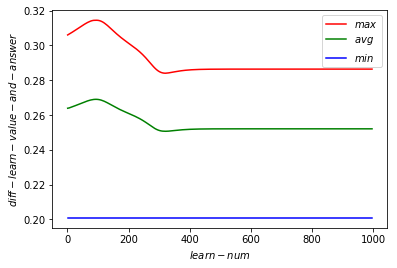

In [278]:
# sotmax Layerを用いたNNモデル
# 多層レイヤー
# トレーニングとして（bitデータの1を与えるとy20は1を返し、y21は反転0を返すものとする)
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
% matplotlib inline

class Layer:
    
    def __init__(self, m, n):  #初期値の設定
        self._rate = 0.1
        self._weight = np.random.rand(m, n) - 0.5  # m行n列を設定(-0.5をすることで-0.5 ~ 0.5の範囲にする)
        self._bias = np.zeros((m, 1))  # m行1列の　0ベクトルを作成してくれている
        self._y = None  # 出力値
        self._delta = None  # 勾配
        
    def set_state(self, x):
        """入力値を内積"""
        s = (self._weight.dot(x))+1*self._bias
        return s

    def logistic(self, s):
        "シグモイド関数"
        self._y = 1 / (1 + np.exp(-s))
        return self._y

    def softmax(self, s):
        "ソフトマックス関数"
        self._y = np.exp(s - np.max(s)) / np.exp(s - np.max(s)).sum()
        return self._y
                        
    
    def logistic_foward(self, x):
        """logistic順伝播"""
        return self.logistic(self.set_state(x))
    def softmax_foward(self, x):
        """softmax順伝播"""
        return self.softmax(self.set_state(x))
    
    def back_propagation(self, prev_W, prev_delta, t):
        """勾配計算(誤差逆伝播)"""
        if prev_W is not None:
            # prev_W(パラメータ)を既に持っている状況：１層目への伝播
#             self._delta = prev_W.T.dot(prev_delta) * self._y  # (V00など2層目パラメータ) * (∂20,21前回delta) * (y10,y11今回出力)
            self._delta = self._y * (1 - self._y) # 1層目の勾配を取得
        else:
            # prev_W(パラメータ)がまだない：2層目を最初に伝播させる
            de = self._y - t  # 正解との誤差
            dy = self._y * (np.identity(len(self._y)) - self._y).T  # softmaxの偏微分
            self._delta = de * dy  # 2層目の勾配を取得
        return self._delta
    
    def update(self):
        """パラメーター更新"""
        self._weight -= self._rate * self._delta.dot(self._weight)
        self._bias -= self._rate * self._delta.dot(self._bias)
        return self._y
    
    def error_function(self, y, o):
        
        print("y[0]とo[0]",y[0],o[0])
        print("y[1]とo[1]",y[1],o[1])
        correct = 1/2 * np.power(y[0] - o[0],2)
        opposite = 1/2 * np.power(y[1] - o[1],2) 
        return correct + opposite

if __name__ == '__main__':
    bit_input = np.array([[[1.]],
                          [[0.]],
                          [[1.]],
                          [[1.]],
                          [[0.]]])
    bit_output = np.array([[[1.],
                            [0.]],
                           [[0.],
                            [1.]],
                           [[1.],
                            [0.]],
                           [[1.],
                            [0.]],
                           [[0.],
                            [1.]]])
    
    n1 = Layer(2,1) # １層目 ：1入力値が列、2出力値が行
    n2 = Layer(2,2) # ２層目 ：2入力値が列、2出力値が行
    prev_W = None  # 
    prev_delta = None
    output_x = []
    tmp_y = []
    output_y_max = []
    output_y_avg = []
    output_y_min = []
    learn_num = 1000
    interval = 5
    for i in tqdm(range(0, learn_num)):
        for input_x, anser in zip(bit_input,bit_output):
            n1_myself_y = n1.logistic_foward(input_x)  # 1層目foward
            n2_myself_y = n2.softmax_foward(n1_myself_y)  # 2層目foward
            n2.back_propagation(prev_W, prev_delta, anser)  # 2層目back(1層目の初期値Wとdeltaとanswerを与える)
            n2_prev_W, n2_delta = n2._weight, n2._delta  # 2層目のWとdeltaを取得
            n1.back_propagation(prev_W, prev_delta, anser)  # 1層目へ伝播
            n1_prev_W, n1_delta = n1._weight, n1._delta

            n2.update() # 2層目のパラメータの更新(1層目の出力値が入力値)
            n1.update() # 1層目のパラメータの更新(初期入力値)
            
            n1_myself_y = n1.logistic_foward(input_x) # 最終的な誤差を計算するために一度foward n1から
            n2_myself_y = n2.softmax_foward(n1_myself_y)  # n2は最後なのでsoftmaxへ
            diff = n1.error_function(n2_myself_y, anser)
            tmp_y.append(diff)
        if i % interval == 0:
            output_y_max.append(max(tmp_y))
            output_y_avg.append(sum(tmp_y) / len(tmp_y))
            output_y_min.append(min(tmp_y))
            tmp_y = []
            output_x.append(i+1)

    # output
    line_max, line_avg, line_min = plt.plot(
        output_x, output_y_max, 'r-', 
        output_x, output_y_avg, 'g-', 
        output_x, output_y_min, 'b-'
    )
    plt.legend((line_max, line_avg, line_min), ('$max$', '$avg$', '$min$'))
    plt.xlabel('$learn-num$')
    plt.ylabel('$diff-learn-value-and-answer$')
    plt.show()